In this notebook, we will perform Bayesian inference (BI) for tension measurements in pendant drop method. 

First we need to importing the image generation codes and some standard libraries.

In [7]:
# image generation codes
from codes_gendrops_py.genSingleDrop import genSingleDrop

# standard libraries
import numpy as np
import matplotlib.pyplot as plt
import scipy.optimize as opt

# use Latex for the lables in plots
plt.rcParams['text.usetex'] = True
plt.rcParams.update({'font.size': 22})

# fix the seed for the RNG
RANDOM_SEED=5109
np.random.seed(RANDOM_SEED)


FileNotFoundError: [Errno 2] No such file or directory: './images_notupload/s75.00_v15.00_rn0.50.jpg'

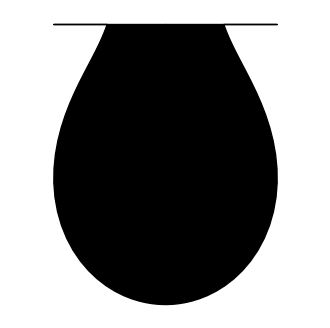

In [8]:
genSingleDrop(sigma=75,volume0=15,rneedle=0.5)